In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn
import seaborn as sns
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.cluster import KMeans
from tqdm import tqdm
# For dimension reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [3]:
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv("BBC News Test.csv")
train_df.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
categories = train_df['Category'].unique()
print(categories)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [5]:
def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [6]:
train_df['Text'] = train_df['Text'].apply(preprocessDataset)
text = train_df['Text']
category = train_df['Category']
text.head()

0    worldcom ex bos launch defenc lawyer defend fo...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster well funkie...
4    enron bos m payout eighteen former enron direc...
Name: Text, dtype: object

In [7]:
# Initialize a vectorizer object
tfidf = TfidfVectorizer()

# Fit transform the clean article to create vectors
article_vectors = tfidf.fit_transform(train_df['Text'])

In [8]:
# Initialize a SVD object
svd = TruncatedSVD(1000)

# Transform the data
reduced_articles = svd.fit_transform(article_vectors)

In [9]:
# To store sum  of squared distances for each number of cluster
SSD = []

# For each number of cluster k
for k in tqdm(range(2,10), colour='yellow'):
    # Initialize a model
    km = KMeans(n_clusters=k)
    # Fit the model
    km = km.fit(reduced_articles)
    # Append the sum of squared distances
    SSD.append(km.inertia_)

100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


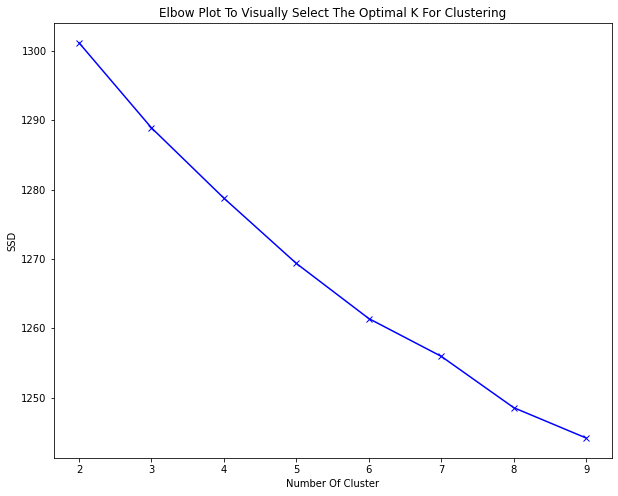

In [10]:
# Ploting an elbow plot (Num of clusters VS Sum of squared distances)
plt.figure(figsize=(10,8))
plt.title("Elbow Plot To Visually Select The Optimal K For Clustering")
plt.plot(range(2,10),SSD,'bx-')
plt.xlabel("Number Of Cluster")
plt.ylabel("SSD")
plt.show()

In [11]:
# Initialize the model
kmeans = KMeans(n_clusters=5)

# Fit on the data
kmeans.fit(reduced_articles)

# Get the labels
labels = kmeans.labels_

In [12]:
# Create a dictionary
df_dict = {"news":train_df["Text"], 'labels_km':labels}

# Convert to dataframe 
df = pd.DataFrame(df_dict)

# Print head
df.head()

,news,labels_km
0,worldcom ex bos launch defenc lawyer defend fo...,0
1,german busi confid slide german busi confid fe...,0
2,bbc poll indic econom gloom citizen major nati...,0
3,lifestyl govern mobil choic faster well funkie...,4
4,enron bos m payout eighteen former enron direc...,0


In [13]:
# Initlalize the tnse object
tsne = TSNE(n_components=2)

# Transform the data
tsne_data = tsne.fit_transform(reduced_articles)

# Convert to Dataframe
tsne_df = pd.DataFrame(tsne_data, columns=['comp1','comp2'])

c:\Users\ajaoo\Downloads\search_flask\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\ajaoo\Downloads\search_flask\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


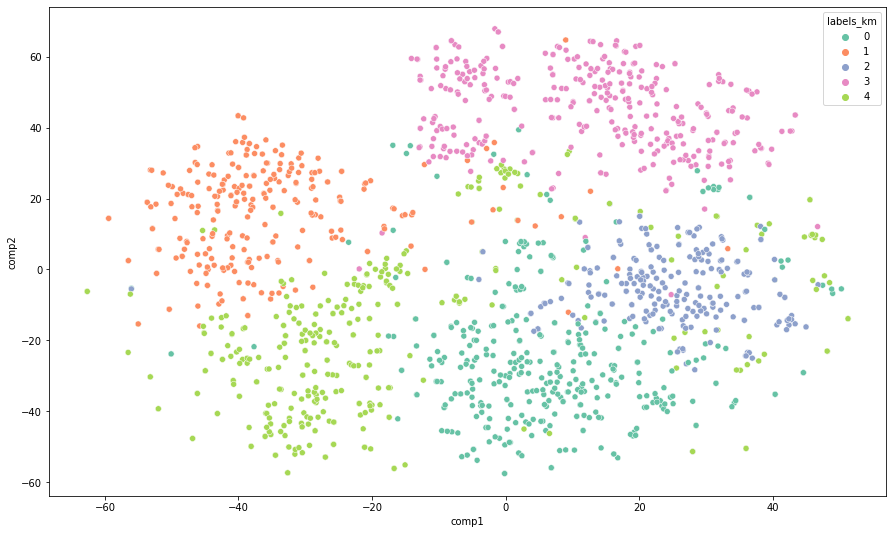

In [14]:
def tsne_viz(tsne_df,labels,label_col='',ax=False):
    if not ax:
        plt.figure(figsize=(15,9))
        sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels,palette='Set2')
        plt.show()
    else:
        ax.set_title(f"Visualising the clusters of {label_col} using TSNE")
        sns.scatterplot(x=tsne_df['comp1'],y=tsne_df['comp2'],hue=labels,palette='Set2',ax=ax) 
        
tsne_viz(tsne_df,df['labels_km'])